In [1]:
%cd ~/src/second-best-bench/
import pandas as pd
import json

/home/yimingz3/src/second-best-bench


In [2]:
train_df = pd.read_json("data/classifier/train.jsonl", lines=True)
val_df = pd.read_json("data/classifier/val.jsonl", lines=True)

In [3]:
def truncate(s):
    return '\n'.join(s.split('\n')[:-5])

val_df["generation_0"] = val_df["generation_0"].map(truncate)
val_df["generation_1"] = val_df["generation_1"].map(truncate)

In [4]:
from src.partition import bleu, rouge1, bertscore, classifier_score, gpt4o_mini_score, gpt35_turbo_score, load_deberta_tokenizer_and_model

/home/yimingz3/miniconda3/envs/second-best-bench/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
bleu_scores = []
rouge_scores = []
bertscore_scores = []
classifier_scores = []
gpt4o_mini_scores = []
gpt35_turbo_scores = []

for _, row in val_df.iterrows():
    prompt, g0, g1 = row["prompt"], row["generation_0"], row["generation_1"]
    bleu_scores.append(await bleu(prompt, g0, g1))
    rouge_scores.append(await rouge1(prompt, g0, g1))
    bertscore_scores.append(await bertscore(prompt, g0, g1))
    classifier_scores.append(await classifier_score(prompt, g0, g1))
    gpt4o_mini_scores.append(await gpt4o_mini_score(prompt, g0, g1))
    gpt35_turbo_scores.append(await gpt35_turbo_score(prompt, g0, g1))


In [7]:
val_df["bleu"] = bleu_scores
val_df["rouge"] = rouge_scores
val_df["bertscore"] = bertscore_scores
val_df["classifier"] = classifier_scores
val_df["gpt-3.5-turbo"] = gpt35_turbo_scores
val_df["gpt-4o-mini"] = gpt4o_mini_scores

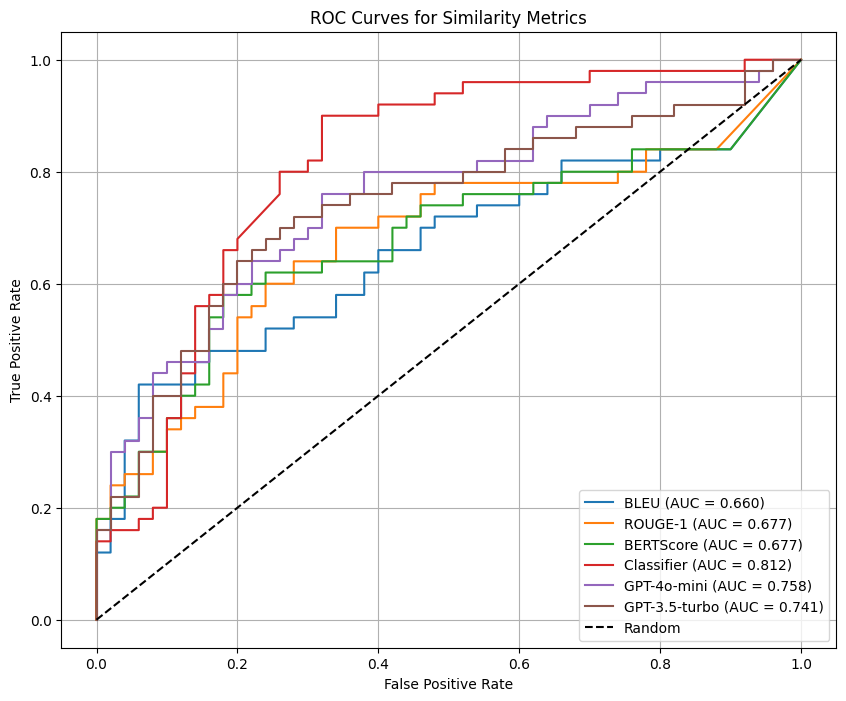


AUC Scores:
BLEU: 0.660
ROUGE-1: 0.677
BERTScore: 0.677
Classifier: 0.812
GPT-4o-mini: 0.758
GPT-3.5-turbo: 0.741


In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curves for each metric
fpr_bleu, tpr_bleu, _ = roc_curve(val_df["similar"], bleu_scores)
fpr_rouge, tpr_rouge, _ = roc_curve(val_df["similar"], rouge_scores)
fpr_bert, tpr_bert, _ = roc_curve(val_df["similar"], bertscore_scores)
fpr_classifier, tpr_classifier, _ = roc_curve(val_df["similar"], classifier_scores)
fpr_gpt4o, tpr_gpt4o, _ = roc_curve(val_df["similar"], gpt4o_mini_scores)
fpr_gpt35, tpr_gpt35, _ = roc_curve(val_df["similar"], gpt35_turbo_scores)

# Calculate AUC scores
auc_bleu = auc(fpr_bleu, tpr_bleu)
auc_rouge = auc(fpr_rouge, tpr_rouge)
auc_bert = auc(fpr_bert, tpr_bert)
auc_classifier = auc(fpr_classifier, tpr_classifier)
auc_gpt4o = auc(fpr_gpt4o, tpr_gpt4o)
auc_gpt35 = auc(fpr_gpt35, tpr_gpt35)


# Create the plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_bleu, tpr_bleu, label=f'BLEU (AUC = {auc_bleu:.3f})')
plt.plot(fpr_rouge, tpr_rouge, label=f'ROUGE-1 (AUC = {auc_rouge:.3f})')
plt.plot(fpr_bert, tpr_bert, label=f'BERTScore (AUC = {auc_bert:.3f})')
plt.plot(fpr_classifier, tpr_classifier, label=f'Classifier (AUC = {auc_classifier:.3f})')
plt.plot(fpr_gpt4o, tpr_gpt4o, label=f'GPT-4o-mini (AUC = {auc_gpt4o:.3f})')
plt.plot(fpr_gpt35, tpr_gpt35, label=f'GPT-3.5-turbo (AUC = {auc_gpt35:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Similarity Metrics')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC scores
print("\nAUC Scores:")
print(f"BLEU: {auc_bleu:.3f}")
print(f"ROUGE-1: {auc_rouge:.3f}")
print(f"BERTScore: {auc_bert:.3f}")
print(f"Classifier: {auc_classifier:.3f}")
print(f"GPT-4o-mini: {auc_gpt4o:.3f}")
print(f"GPT-3.5-turbo: {auc_gpt35:.3f}")

In [13]:

import altair as alt
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Calculate ROC curves for each metric
fpr_bleu, tpr_bleu, _ = roc_curve(val_df["similar"], bleu_scores)
fpr_rouge, tpr_rouge, _ = roc_curve(val_df["similar"], rouge_scores)
fpr_bert, tpr_bert, _ = roc_curve(val_df["similar"], bertscore_scores)
fpr_classifier, tpr_classifier, _ = roc_curve(val_df["similar"], classifier_scores)
fpr_gpt4o, tpr_gpt4o, _ = roc_curve(val_df["similar"], gpt4o_mini_scores)
fpr_gpt35, tpr_gpt35, _ = roc_curve(val_df["similar"], gpt35_turbo_scores)

# Calculate AUC scores
auc_bleu = auc(fpr_bleu, tpr_bleu)
auc_rouge = auc(fpr_rouge, tpr_rouge)
auc_bert = auc(fpr_bert, tpr_bert)
auc_classifier = auc(fpr_classifier, tpr_classifier)
auc_gpt4o = auc(fpr_gpt4o, tpr_gpt4o)
auc_gpt35 = auc(fpr_gpt35, tpr_gpt35)

# Create a DataFrame for Altair
roc_data = pd.DataFrame({
    'fpr': np.concatenate([fpr_bleu, fpr_rouge, fpr_bert, fpr_classifier, fpr_gpt4o, fpr_gpt35, [0, 1]]),
    'tpr': np.concatenate([tpr_bleu, tpr_rouge, tpr_bert, tpr_classifier, tpr_gpt4o, tpr_gpt35, [0, 1]]),
    'metric': ['BLEU'] * len(fpr_bleu) + ['ROUGE-1'] * len(fpr_rouge) + ['BERTScore'] * len(fpr_bert) + \
              ['Classifier'] * len(fpr_classifier) + ['GPT-4o-mini'] * len(fpr_gpt4o) + ['GPT-3.5-turbo'] * len(fpr_gpt35) + ['Random'] * 2,
    'auc': [auc_bleu] * len(fpr_bleu) + [auc_rouge] * len(fpr_rouge) + [auc_bert] * len(fpr_bert) + \
           [auc_classifier] * len(fpr_classifier) + [auc_gpt4o] * len(fpr_gpt4o) + [auc_gpt35] * len(fpr_gpt35) + [0.5] * 2  # AUC for random is 0.5
})

# Create the plot with Altair
chart = alt.Chart(roc_data).mark_line(point=False).encode(
    x=alt.X('fpr:Q', title='False Positive Rate', axis=alt.Axis(format='%')),
    y=alt.Y('tpr:Q', title='True Positive Rate', axis=alt.Axis(format='%')),
    color=alt.Color('metric:N', title='Metric'),
    tooltip=['metric', 'auc']
).properties(
    title='ROC Curves for Similarity Metrics'
)

# Add AUC values to the legend
chart = chart.encode(
    color=alt.Color('metric:N', title='Metric')  # Format AUC values
).transform_calculate(
    metric_auc=alt.datum.metric + ' (AUC=' + alt.expr.round(alt.datum.auc * 100) / 100 + ')'
)

chart = chart.encode(
    color=alt.Color('metric_auc:N', title='Metric')
)


# Display the chart
chart.show()

# Print AUC scores
print("\nAUC Scores:")
print(f"BLEU: {auc_bleu:.3f}")
print(f"ROUGE-1: {auc_rouge:.3f}")
print(f"BERTScore: {auc_bert:.3f}")
print(f"Classifier: {auc_classifier:.3f}")
print(f"GPT-4o-mini: {auc_gpt4o:.3f}")
print(f"GPT-3.5-turbo: {auc_gpt35:.3f}")


alt.Chart(...)


AUC Scores:
BLEU: 0.660
ROUGE-1: 0.677
BERTScore: 0.677
Classifier: 0.812
GPT-4o-mini: 0.758
GPT-3.5-turbo: 0.741


: 

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def find_best_threshold(y_true, scores):
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0
    best_accuracy = 0
    thresholds = np.linspace(0, 1, 1000)  # Test 1000 threshold values
    
    for threshold in thresholds:
        y_pred = (scores >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision_score(y_true, y_pred)
            best_recall = recall_score(y_true, y_pred)
            best_accuracy = accuracy
    
    return best_threshold, best_precision, best_recall, best_f1, best_accuracy

# Find best thresholds and scores
bleu_threshold, bleu_precision, bleu_recall, bleu_f1, bleu_accuracy = find_best_threshold(val_df["similar"], bleu_scores)
rouge_threshold, rouge_precision, rouge_recall, rouge_f1, rouge_accuracy = find_best_threshold(val_df["similar"], rouge_scores)
bert_threshold, bert_precision, bert_recall, bert_f1, bert_accuracy = find_best_threshold(val_df["similar"], bertscore_scores)
classifier_threshold, classifier_precision, classifier_recall, classifier_f1, classifier_accuracy = find_best_threshold(val_df["similar"], classifier_scores)
gpt4o_threshold, gpt4o_precision, gpt4o_recall, gpt4o_f1, gpt4o_accuracy = find_best_threshold(val_df["similar"], gpt4o_mini_scores)
gpt35_threshold, gpt35_precision, gpt35_recall, gpt35_f1, gpt35_accuracy = find_best_threshold(val_df["similar"], gpt35_turbo_scores)


print("\nOptimal Thresholds and Metrics:")
print(f"BLEU: threshold = {bleu_threshold:.3f}")
print(f"  Precision: {bleu_precision:.3f}")
print(f"  Recall: {bleu_recall:.3f}")
print(f"  F1: {bleu_f1:.3f}")
print(f"  Accuracy: {bleu_accuracy:.3f}")

print(f"\nROUGE-1: threshold = {rouge_threshold:.3f}")
print(f"  Precision: {rouge_precision:.3f}")
print(f"  Recall: {rouge_recall:.3f}")
print(f"  F1: {rouge_f1:.3f}")
print(f"  Accuracy: {rouge_accuracy:.3f}")

print(f"\nBERTScore: threshold = {bert_threshold:.3f}")
print(f"  Precision: {bert_precision:.3f}")
print(f"  Recall: {bert_recall:.3f}")
print(f"  F1: {bert_f1:.3f}")
print(f"  Accuracy: {bert_accuracy:.3f}")

print(f"\nClassifier: threshold = {classifier_threshold:.3f}")
print(f"  Precision: {classifier_precision:.3f}")
print(f"  Recall: {classifier_recall:.3f}")
print(f"  F1: {classifier_f1:.3f}")
print(f"  Accuracy: {classifier_accuracy:.3f}")

print(f"\nGPT-4o-mini: threshold = {gpt4o_threshold:.3f}")
print(f"  Precision: {gpt4o_precision:.3f}")
print(f"  Recall: {gpt4o_recall:.3f}")
print(f"  F1: {gpt4o_f1:.3f}")
print(f"  Accuracy: {gpt4o_accuracy:.3f}")

print(f"\nGPT-3.5-turbo: threshold = {gpt35_threshold:.3f}")
print(f"  Precision: {gpt35_precision:.3f}")
print(f"  Recall: {gpt35_recall:.3f}")
print(f"  F1: {gpt35_f1:.3f}")
print(f"  Accuracy: {gpt35_accuracy:.3f}")


Optimal Thresholds and Metrics:
BLEU: threshold = 0.000
  Precision: 0.500
  Recall: 1.000
  F1: 0.667
  Accuracy: 0.500

ROUGE-1: threshold = 0.415
  Precision: 0.619
  Recall: 0.780
  F1: 0.690
  Accuracy: 0.650

BERTScore: threshold = 0.732
  Precision: 0.617
  Recall: 0.740
  F1: 0.673
  Accuracy: 0.640

Classifier: threshold = 0.102
  Precision: 0.738
  Recall: 0.900
  F1: 0.811
  Accuracy: 0.790

GPT-4o-mini: threshold = 0.000
  Precision: 0.500
  Recall: 1.000
  F1: 0.667
  Accuracy: 0.500

GPT-3.5-turbo: threshold = 0.000
  Precision: 0.500
  Recall: 1.000
  F1: 0.667
  Accuracy: 0.500


In [23]:
def construct_finetuning_data(df):
    SYS_PROMPT = "Below, you will see two responses to the a prompt. Determine if the two responses are meaningfully different, so that a user who has seen one of the responses would likely benefit from seeing the other. Output \"Similar\" or \"Different\" only."
    data = []
    for _, row in df.iterrows():
        prompt = row["prompt"]
        generation_0 = row["generation_0"]
        generation_1 = row["generation_1"]
        similar = row["similar"]
        data.append({"messages": [
                {"role": "system", "content": SYS_PROMPT},
                {"role": "user", "content": f"====== Prompt ======\n{prompt}\n\n====== Response 1 ======\n{generation_0}\n\n====== Response 2 ======\n{generation_1}"},
                {"role": "assistant", "content": "Similar" if similar else "Different"},
            ]})

    return data

In [46]:
train_data = construct_finetuning_data(train_df)
val_data = construct_finetuning_data(val_df)

with open("data/classifier/oai-train.jsonl", "w") as f:
    for l in train_data:
        json.dump(l, f)
        f.write('\n')

with open("data/classifier/oai-val.jsonl", "w") as f:
    for l in val_data:
        json.dump(l, f)
        f.write('\n')

In [23]:
from openai import OpenAI

with open("/home/yimingz3/secrets/openai-api-key") as f:
    client = OpenAI(api_key=f.read().strip())


In [49]:


train_file = client.files.create(
  file=open("data/classifier/oai-train.jsonl", "rb"),
  purpose="fine-tune"
)

val_file = client.files.create(
  file=open("data/classifier/oai-val.jsonl", "rb"),
  purpose="fine-tune"
)

In [52]:
val_file

FileObject(id='file-KK45NbpSD29aJ5tLjFKhnJ', bytes=427735, created_at=1741213653, filename='oai-val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [53]:
TRAIN = "file-PanCSr5pnssA1V1F6wo3Xk"
VAL = "file-KK45NbpSD29aJ5tLjFKhnJ"

In [72]:
client.fine_tuning.jobs.create(
    training_file=TRAIN,
    validation_file=VAL,
    model="gpt-4o-mini-2024-07-18"
)


FineTuningJob(id='ftjob-pIiaZmKvcZC7hVtfDo9wiOkH', created_at=1741213815, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-IslPo3VfLD3jMpgqIecgtXzQ', result_files=[], seed=748959171, status='validating_files', trained_tokens=None, training_file='file-PanCSr5pnssA1V1F6wo3Xk', validation_file='file-KK45NbpSD29aJ5tLjFKhnJ', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto')), type='supervised'), user_provided_suffix=None, metadata=None)

In [12]:
job = client.fine_tuning.jobs.retrieve("ftjob-pIiaZmKvcZC7hVtfDo9wiOkH")

In [13]:
job

FineTuningJob(id='ftjob-pIiaZmKvcZC7hVtfDo9wiOkH', created_at=1741213815, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:lti-carnegie-mellon-university::B7serxIF', finished_at=1741218100, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=3), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-IslPo3VfLD3jMpgqIecgtXzQ', result_files=['file-BPGuRQxm5eEES6Bbw5255e'], seed=748959171, status='succeeded', trained_tokens=1616121, training_file='file-PanCSr5pnssA1V1F6wo3Xk', validation_file='file-KK45NbpSD29aJ5tLjFKhnJ', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=3)), type='supervised'), user_provided_suffix=None, metadata=None)

In [17]:
content = client.files.content("file-BPGuRQxm5eEES6Bbw5255e")

In [86]:
SYS_PROMPT = "Below, you will see two responses to the a prompt. Determine if the two responses are meaningfully different, so that a user who has seen one of the responses would likely benefit from seeing the other. Output \"Similar\" or \"Different\" only."
prompt = "Choosing a LLM API to use. Recommend one."
generation_0 = "GPT-3.5-turbo."
generation_1 = "GPT-3.5"

completion = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:lti-carnegie-mellon-university::B7serxIF",
    # model="ft:gpt-3.5-turbo-0125:lti-carnegie-mellon-university::B7sns97b",
    messages=[
                {"role": "system", "content": SYS_PROMPT},
                {"role": "user", "content": f"====== Prompt ======\n{prompt}\n\n====== Response 1 ======\n{generation_0}\n\n====== Response 2 ======\n{generation_1}"},
            ],
    temperature=0.0,
    logprobs=True,
    top_logprobs=10,
    max_tokens=1
)

logit_similar = logit_different = -99
for logprob in completion.choices[0].logprobs.content[0].top_logprobs:
    if logprob.token == "Similar":
        logit_similar = logprob.logprob
    if logprob.token == "Different":
        logit_different = logprob.logprob

probs = np.exp([logit_similar, logit_different])
probs = probs / probs.sum()
p_similar = probs[0]


In [87]:
p_similar

0.9998147741105742